In [2]:
import iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import datetime
import shutil
from six.moves import urllib
from pathlib import Path
import trackpy
from iris.time import PartialDateTime

import tobac #tobac package cloned from https://github.com/tobac-project/tobac.git

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [3]:
#load in file
data_out=('../')
data_file = '/data/users/hgilmour/olr/olr_1h/2005/olr_merge_jan_2005.nc' #this is the 1 hourly mean olr data for the first 20 days of 1998
print(data_file)

olr=iris.load_cube(data_file)


#constraining the dataset by time so it runs quicker: 
week=iris.Constraint(time=lambda cell: cell.point.day<=7) #just the first 7 days
olr = olr.extract(week)

olr.coord('time').bounds=None #REMOVING BOUNDS FROM TIME TO SEE IF THIS HELPS THE TYPEERROR
# Remove coord system or else the animations don't run (suggested by AVD team)
olr.coord('latitude').coord_system = None
olr.coord('longitude').coord_system = None

#code that AVD team sent:
time = olr.coord('time')
datetimes = time.units.num2date(time.points)
con = iris.Constraint(time=datetimes[0])
olr.extract(con)


print(olr)

#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()      


#calculating dxy
from math import pi
longitude,latitude=np.meshgrid(olr.coord('longitude').points,olr.coord('latitude').points)
R=6.3781e6
dx=np.gradient(longitude)[1]
dx=dx*(pi/180)*R*np.cos(latitude*pi/180)
dy=np.gradient(latitude)[0]
dy=dy*(pi/180)*R
print(dx)
print(dy)


# Determine temporal and spatial sampling of the input data:
dxy,dt=tobac.get_spacings(olr,grid_spacing=4500,time_spacing=3600) #time spacing = 1 hour

/data/users/hgilmour/olr/olr_1h/2005/olr_merge_jan_2005.nc
toa_outgoing_longwave_flux / (W m-2) (time: 168; latitude: 1360; longitude: 1360)
    Dimension coordinates:
        time                              x              -                -
        latitude                          -              x                -
        longitude                         -              -                x
    Auxiliary coordinates:
        forecast_period                   x              -                -
    Scalar coordinates:
        forecast_reference_time      2002-01-01 00:00:00
    Cell methods:
        mean                         time (1 hour)
    Attributes:
        Conventions                  'CF-1.7'
        STASH                        m01s03i332
        source                       'Data from Met Office Unified Model'
        um_version                   '10.6'
[[3451.3477 3451.3477 3451.3477 ... 3451.3477 3451.3477 3451.3477]
 [3453.3967 3453.3967 3453.3967 ... 3453.3967 3453.3967 

In [4]:
dxy,dt=tobac.get_spacings(olr,grid_spacing=4500,time_spacing=3600) #time spacing = 1 hour


#Convert from olr to Tb using Ohring and Gruber empirical formula:
# # (1984) as given in Yang and Slingo (2001)
    # Tf = tb(a+b*Tb) where a = 1.228 and b = -1.106e-3 K^-1
    # OLR = sigma*Tf^4 
    # where sigma = Stefan-Boltzmann constant = 5.67x10^-8 W m^-2 K^-4
a = 1.228
b = -1.106e-3
sigma = 5.67e-8 # W m^-2 K^-4

tf = (olr.data/5.67e-8)**0.25
tb_var = (-1.228 + np.sqrt(1.228**2 + 4*-1.106e-3*tf.data))/(2*-1.106e-3)

tb=olr.copy()
tb.data=tb_var.data
print(tb)

toa_outgoing_longwave_flux / (W m-2) (time: 168; latitude: 1360; longitude: 1360)
    Dimension coordinates:
        time                              x              -                -
        latitude                          -              x                -
        longitude                         -              -                x
    Auxiliary coordinates:
        forecast_period                   x              -                -
    Scalar coordinates:
        forecast_reference_time      2002-01-01 00:00:00
    Cell methods:
        mean                         time (1 hour)
    Attributes:
        Conventions                  'CF-1.7'
        STASH                        m01s03i332
        source                       'Data from Met Office Unified Model'
        um_version                   '10.6'


In [5]:

#Parameter features:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['target']='minimum'
parameters_features['threshold']=[240,210] #olr threshold equivalent to Tb=225K based on stefan boltzmann equation (145 for 225K, 91 for 200K, 74 for 190K)
parameters_features['n_min_threshold']=1975 # number of grid points for 40,000km^2 area (7792m = 1 grid space. 4500m x 4500m = 20250000m^2. 40,000km^2 = 4x10^10m^2. 4x10^10 / 20250000 = 1975 (1975 grid cells per 40,000km^2 area)

# Feature detection and save results to file:
print('starting feature detection')
Features=tobac.feature_detection_multithreshold(tb,dxy,**parameters_features)
Features.to_hdf(savedir / 'Features.h5','table')
print('feature detection performed and saved')

starting feature detection
feature detection performed and saved


In [6]:
# Segmentation:
parameters_segmentation={}
parameters_segmentation['target']='minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=240


# Perform segmentation and save results to files:
Mask_tb,Features_tb=tobac.segmentation_2D(Features,tb,dxy,**parameters_segmentation)
print('segmentation tb performed, start saving results to files')
iris.save([Mask_tb], savedir / 'Mask_Segmentation_tb.nc', zlib=True, complevel=4)
Features_tb.to_hdf(savedir / 'Features_tb.h5', 'table')
print('segmentation tb performed and saved')

segmentation tb performed, start saving results to files
segmentation tb performed and saved


In [7]:
# Linking:
parameters_linking={}
parameters_linking['v_max']=60 #(velocity of 60 m s-1 is referenced in https://journals.ametsoc.org/view/journals/mwre/126/6/1520-0493_1998_126_1630_lcvomc_2.0.co_2.xml#i1520-0493-126-6-1630-f01 study)
parameters_linking['stubs']=7 #minimum number of timesteps for a tracked cell to be reported (equivalent to 6 hours)
parameters_linking['order']=1
parameters_linking['extrapolate']=0 
parameters_linking['memory']=0
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['subnetwork_size']=15
parameters_linking['method_linking']= 'predict'



# Perform linking and save results to file:
Track=tobac.linking_trackpy(Features,tb,dt=dt,dxy=dxy,**parameters_linking)
Track["longitude"]=Track["longitude"]-360
Track.to_hdf(savedir / 'Track.h5','table')


Frame 167: 20 trajectories present.


<Figure size 640x480 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

<Figure size 3000x2800 with 0 Axes>

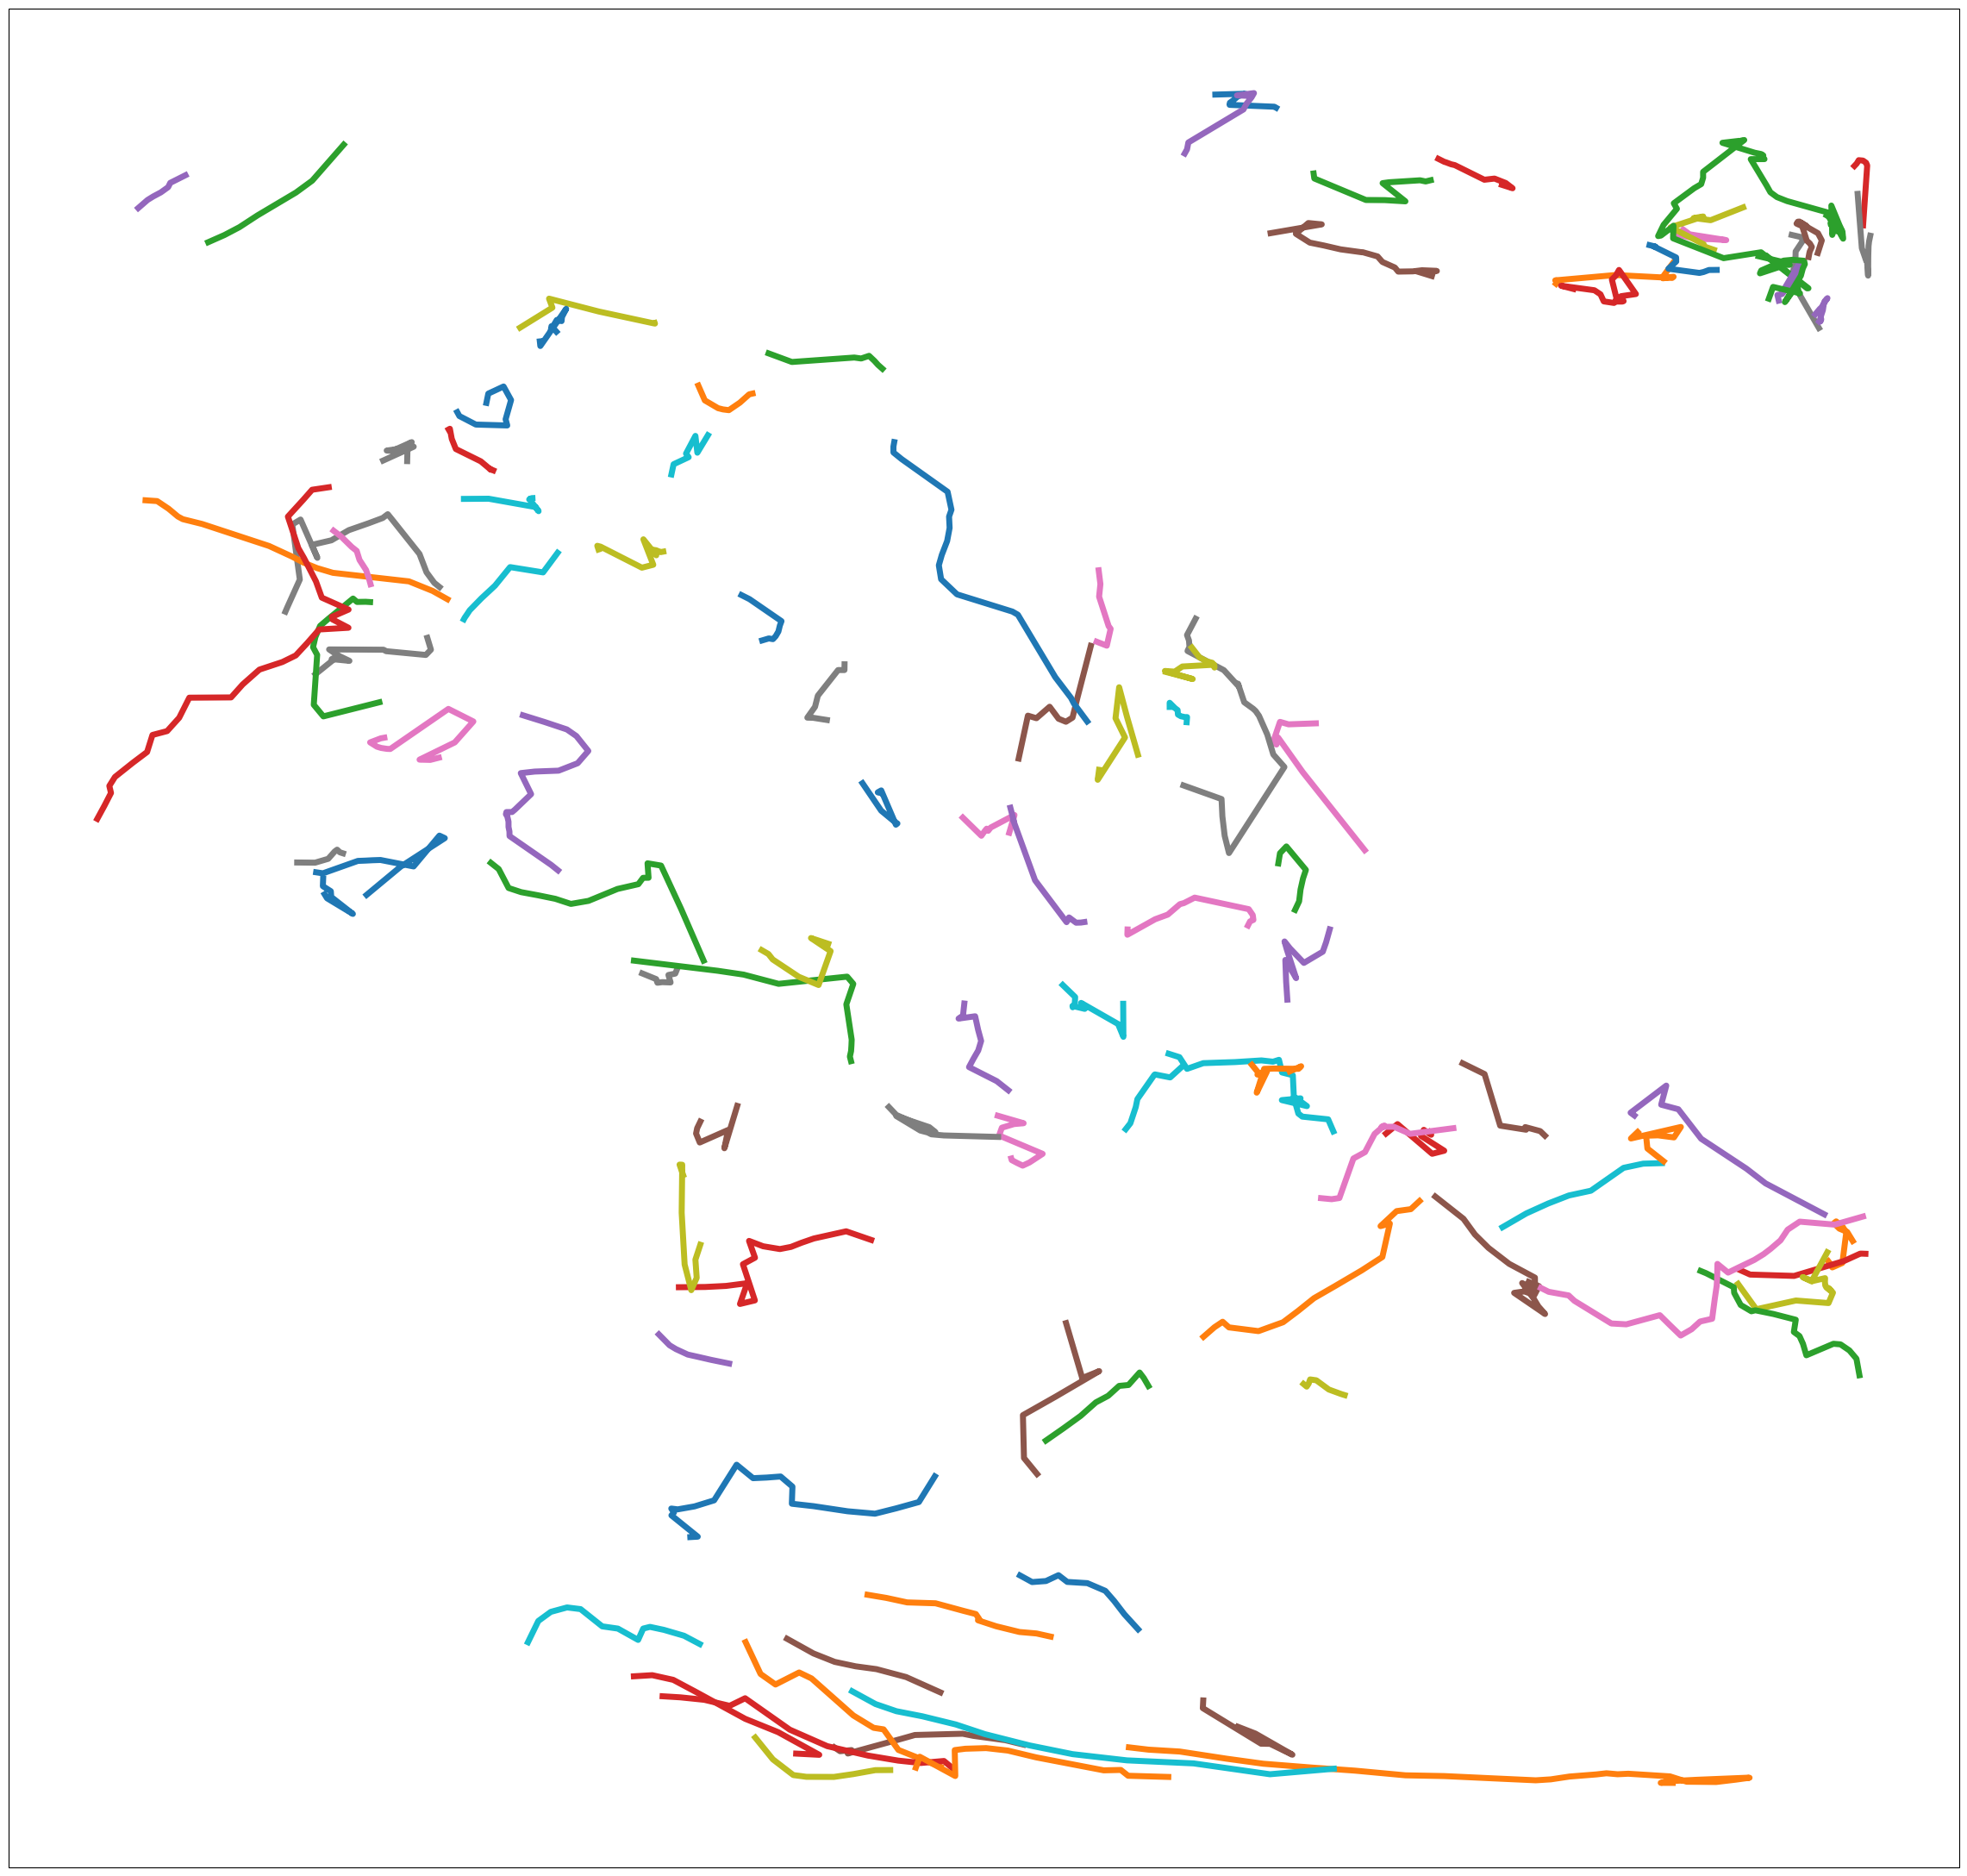

In [35]:
#plots for each timestep:
#========================

#creating list of dates and times for the plot titles:
time = tb.coord('time')
dates = time.units.num2date(time.points)

import cartopy.crs as ccrs
axis_extent=[-80,-30,-35,12]

#loop for each timestep:
plt.figure()

fig_map,ax_map=plt.subplots(figsize=(30,28),subplot_kw={'projection': ccrs.PlateCarree()})
for cell in Track['cell'].dropna().unique():
    if cell == -1:
        continue
    Track_i = Track[Track['cell'] == cell]
    plt.plot(Track_i['longitude'],Track_i['latitude'], '-',linewidth=5,zorder=2)

hours = np.arange(0,71)

for i in hours: 
    mask = iplt.contour(Mask_tb[i,:,:],colors='k',linewidth=2)
    Tb = iplt.pcolormesh(tb[i,:,:],cmap='Blues',alpha=0.9,vmin=0,vmax=400)
    plt.gca().coastlines(linewidth=3)
    cbar = plt.colorbar(fraction=0.046, pad=0.03)
    cbar.ax.tick_params(labelsize=30)
    plt.clim(180,355)
    cbar.set_label('Tb (K)',rotation=270,labelpad=15,fontsize=40)
    time = Features[Features['frame']==i]
    plt.scatter(x=time['longitude'],y=time['latitude'],c='k',marker='x',s=200,linewidth=4,zorder=5)	
    plt.xticks([-80,-70,-60,-50,-40,-30],fontsize=30)
    plt.yticks([-40,-30,-20,-10,0,10],fontsize=30)
    plt.xlabel('Lon $^\circ$E', fontsize=40)
    plt.ylabel('Lat $^\circ$N', fontsize=40)
    hour = i + 1
    plt.title("{}".format(dates[i]) + "\n(Tb = 240K, Area = 1975 g.s. / 40,000 $km^2$)",fontsize=40)
    plt.savefig('tracks_tb_mask_240K_largeTh' +str(hour) + '.jpg')
    plt.clf()
    fig_map,ax_map=plt.subplots(figsize=(30,28),subplot_kw={'projection': ccrs.PlateCarree()})
    for cell in Track['cell'].dropna().unique():
        if cell == -1:
            continue
        Track_i = Track[Track['cell'] == cell]
        plt.plot(Track_i['longitude'],Track_i['latitude'], '-',linewidth=5,zorder=2)

In [ ]:
##ANIMATION CODE##
import PIL
import numpy as np
from PIL import Image

image_frames=[]

hours = np.arange(1,72)

for k in hours:
	new_frame = PIL.Image.open('tracks_tb_mask_240K_largeTh' +str(k) + '.jpg')
	image_frames.append(new_frame)

image_frames[0].save('tobac_mask_tracks_tb_240K_largeTh.gif', format = 'GIF', append_images = image_frames[1: ], save_all = True, duration = 800, loop = 3)